## Résumé du notebook explo

Dans ce notebook est réalisé le traitement de données EEG pour BCI MI. Le choix a été fait de travailler sur des *sliding windows* extraites d'*Epochs*. L'objectif était de pouvoir extraire suffisament de données pour se contenter d'un entrainement sur un seul patient. 

La pipeline est la suivante:

* Selection du coté lésé
* Epoching du signal autour des mouvements
* Extraction des sliding windows au sein des epochs
* Classification pipeline parmis:
    * CSP + LDA
    * CSP + SVM
    * xDAWN + vectorizer + scaler + logreg

Conclusion, résultats peu probants. Il serait intéressant de finalement entrainer sur multi-patients.

## Notebook Setup

Install the needed packages here.

In [ ]:
# !pip install pyriemann
# !pip install -e ../src
# !pip list

Import the needed packages here.

In [6]:
import os
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

# Matplotlib settings
plt.rcParams['figure.figsize'] = [5, 5]
plt.rcParams['figure.dpi'] = 150

from preprocessing.data_loader import DataLoader

## Data Loading

In [7]:
PATH_DATA_FOLDER = os.path.join(os.getcwd(), '../../data')
PATH_DATA_RAW_FOLDER = f'{PATH_DATA_FOLDER}/raw'
PATH_DATA_RAW_TRIALS = [
    f'{PATH_DATA_RAW_FOLDER}/{f}' \
    for f in os.listdir(PATH_DATA_RAW_FOLDER) if f.endswith('.npy')
]
PATH_DATA_RAW_TRIALS.sort()

for i in range(10):
    print(PATH_DATA_RAW_TRIALS[i])

/media/Data/isae-supaero/3A/PIE/PIE_2023/notebooks/exploration/../../data/raw/DATA_001_Trial1.npy
/media/Data/isae-supaero/3A/PIE/PIE_2023/notebooks/exploration/../../data/raw/DATA_001_Trial2.npy
/media/Data/isae-supaero/3A/PIE/PIE_2023/notebooks/exploration/../../data/raw/DATA_002_Trial1.npy
/media/Data/isae-supaero/3A/PIE/PIE_2023/notebooks/exploration/../../data/raw/DATA_002_Trial2.npy
/media/Data/isae-supaero/3A/PIE/PIE_2023/notebooks/exploration/../../data/raw/DATA_002_Trial3.npy
/media/Data/isae-supaero/3A/PIE/PIE_2023/notebooks/exploration/../../data/raw/DATA_003_Trial1.npy
/media/Data/isae-supaero/3A/PIE/PIE_2023/notebooks/exploration/../../data/raw/DATA_003_Trial2.npy
/media/Data/isae-supaero/3A/PIE/PIE_2023/notebooks/exploration/../../data/raw/DATA_004_Trial1.npy
/media/Data/isae-supaero/3A/PIE/PIE_2023/notebooks/exploration/../../data/raw/DATA_004_Trial2.npy
/media/Data/isae-supaero/3A/PIE/PIE_2023/notebooks/exploration/../../data/raw/DATA_005_Trial1.npy


In [55]:
sample_id = 0
loader = DataLoader(PATH_DATA_RAW_TRIALS[sample_id])
stroke = loader.stroke_side

# Select arm on opposite side of stroke side
arm_side = 'G' if stroke == 'D' else 'G'
eeg_data = loader.get_raws(side=arm_side)

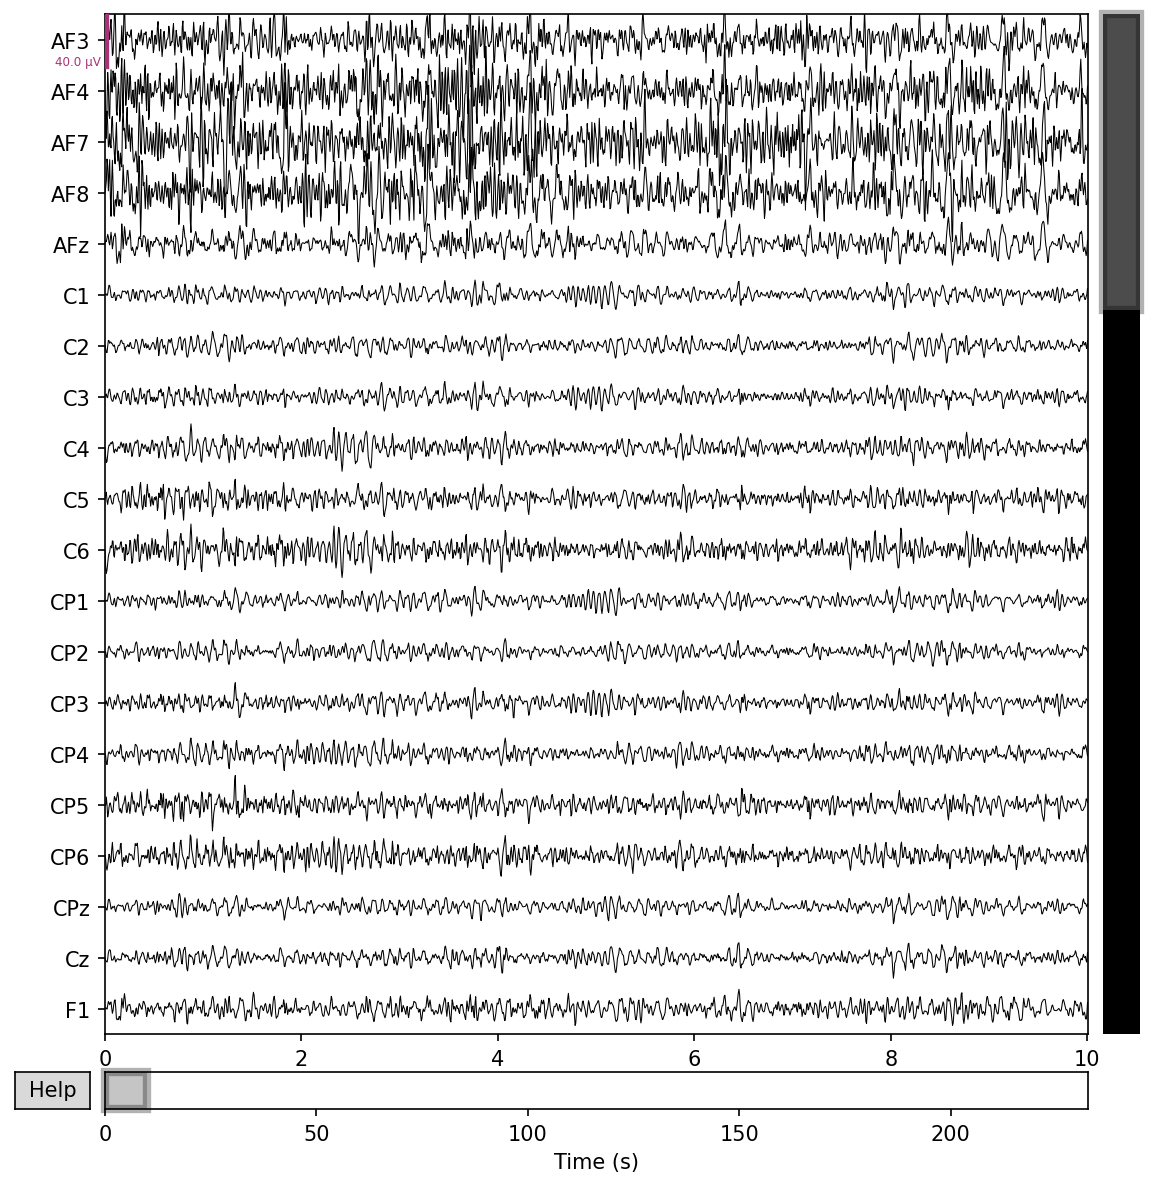

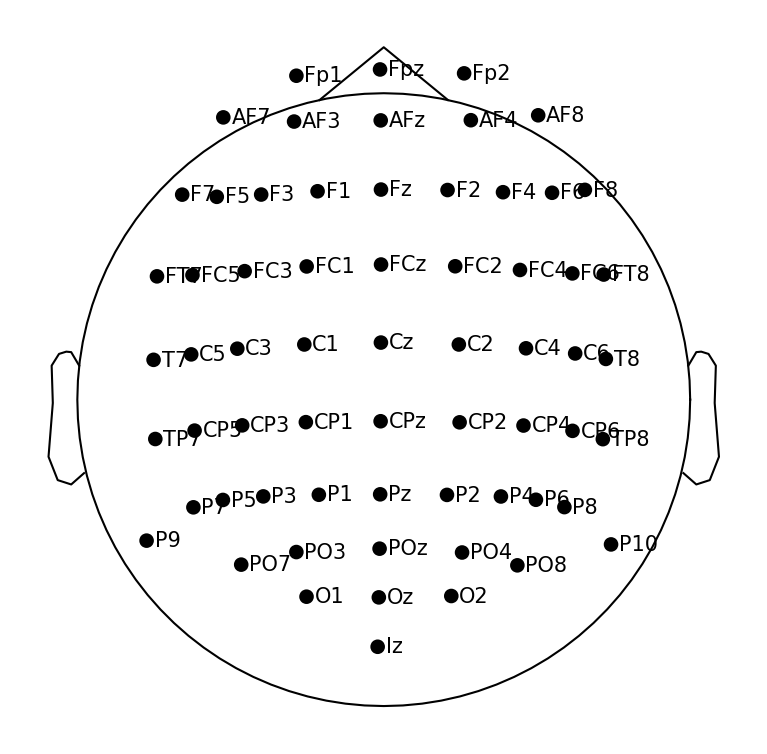

In [57]:
# Plot of the EEG raw signals
eeg_data.plot(lowpass=45, highpass=5)
# Plot configs
eeg_data.plot_sensors(ch_type='eeg', show_names=True)
# Clean output
plt.show()

In [34]:
# Filter only stroke side electrods to avoid working on healthy side electrods.
electrodes_R = [
     'Fz', 'F2', 'F4', 'F6', 'F8',
    'FCz','FC2','FC4','FC6','FT8', 
     'Cz', 'C2', 'C4', 'C6', 'T8',
    'CPz','CP2','CP4','CP6','TP8',
     'Pz', 'P2', 'P4', 'P6', 'P8',
]

electrodes_L = [
     'Fz', 'F1', 'F3', 'F5', 'F7',
    'FCz','FC1','FC3','FC5','FT7', 
     'Cz', 'C1', 'C3', 'C5', 'T7',
    'CPz','CP1','CP3','CP5','TP7',
     'Pz', 'P1', 'P3', 'P5', 'P7',
]

if stroke == 'G':
    mask_elec = electrodes_L
else:
    mask_elec = electrodes_R
mask = mask_elec + ['movement']
data = eeg_data.copy().pick_channels(mask)
data

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,67 points
Good channels,"25 EEG, 1 Stimulus"
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,1024.00 Hz
Highpass,0.00 Hz
Lowpass,512.00 Hz


In [35]:
# Let's save a function to preproc the data for a given subject, with a given stroke_side

def preproc(sample_id):
    loader = DataLoader(PATH_DATA_RAW_TRIALS[sample_id])
    stroke = loader.stroke_side

    # Select arm on opposite side of stroke side
    arm_side = 'G' if stroke == 'D' else 'G'
    eeg_data = loader.get_raws(side=arm_side)

    # Select corresponding electrods
    electrodes_R = [
        'Fz', 'F2', 'F4', 'F6', 'F8',
        'FCz','FC2','FC4','FC6','FT8', 
        'Cz', 'C2', 'C4', 'C6', 'T8',
        'CPz','CP2','CP4','CP6','TP8',
        'Pz', 'P2', 'P4', 'P6', 'P8',
    ]
    electrodes_L = [
        'Fz', 'F1', 'F3', 'F5', 'F7',
        'FCz','FC1','FC3','FC5','FT7', 
        'Cz', 'C1', 'C3', 'C5', 'T7',
        'CPz','CP1','CP3','CP5','TP7',
        'Pz', 'P1', 'P3', 'P5', 'P7',
    ]

    if stroke == 'G':
        mask_elec = electrodes_L
    else:
        mask_elec = electrodes_R
    mask = mask_elec + ['movement']
    data = eeg_data.copy().pick_channels(mask)

    return data

/media/Data/envs/EEGstroke/lib/python3.8/site-packages/mne/viz/utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


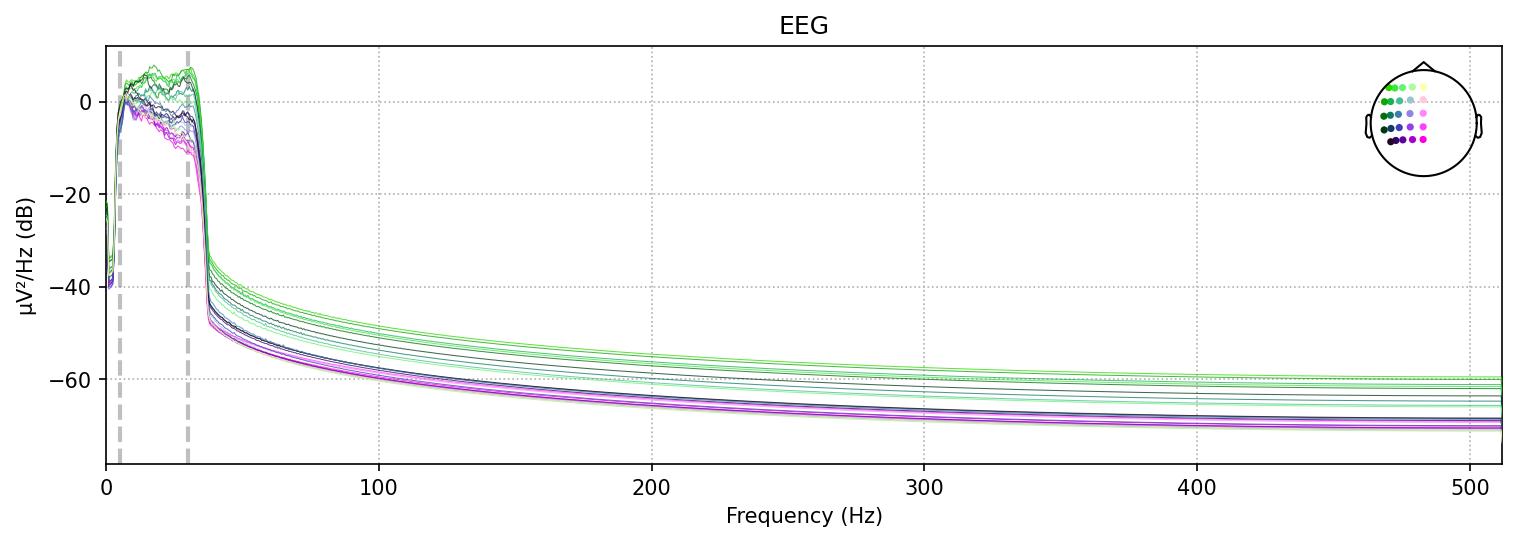

In [58]:
raw_tmp = data.copy()
raw_tmp.filter(5, 30, fir_design='firwin', skip_by_annotation='edges')

raw_tmp.plot_psd()
plt.show()
# raw_tmp.plot_psd_topo()
# plt.show()

## Classification

In [37]:
# Set seed for reproducibility
import numpy as np
np.random.seed(42)

### - **Utils** : Epoching + sub-epoching (window extraction)

In [59]:
from mne import Epochs, find_events

def extract_epochs(raws, 
                   fmin=5, 
                   fmax=50, 
                   tmin=-1.5, 
                   tmax=+1.5):
    # Apply band-pass filter 
    raws.filter(fmin, fmax, fir_design='firwin', skip_by_annotation='edge')
    # Recup events 
    events = find_events(raws, stim_channel='movement')
    # Apply epoching around events
    epochs = Epochs(raws, events, event_id=None, tmin=tmin, tmax=tmax, preload=True)
    labels = epochs.events[:, -1] - 1

    # Remove movement channel
    epochs = epochs.copy().pick_channels(mask_elec)

    return epochs, labels

In [60]:
def extract_windows(epochs, w_size=1.0, w_step=0.1):
    # Define windows size and step in samples
    w_size_samp = int(w_size * epochs.info['sfreq'])
    w_step_samp = int(w_step * epochs.info['sfreq'])
    w_start = np.arange(0, epochs.get_data().shape[2] - w_size_samp, w_step_samp)
    w_event = epochs.get_data().shape[2] // 2

    # Extract windows and targets
    windows = []
    targets = []
    for j in range(epochs.get_data().shape[0]):
        windows_epoch = []
        targets_epoch = []
        for i in w_start:
            windows_epoch.append(epochs.get_data()[j, :, i:i + w_size_samp])
            if i <= w_event <= i + w_size_samp:
                targets_epoch.append(1)
            else:
                targets_epoch.append(0)
        
        windows.append(np.array(windows_epoch))
        targets.append(np.array(targets_epoch))
    
    windows = np.concatenate(windows)
    targets = np.concatenate(targets)

    return windows, targets


In [61]:
data_sample_id = preproc(sample_id)

# Temporal Filter 
tfilter_fmin = 8
tfilter_fmax = 25
epochs, labels = extract_epochs(data_sample_id, 
                                fmin=tfilter_fmin, 
                                fmax=tfilter_fmax) 
print("epochs shape:", epochs.get_data().shape)
print("labels shape:", labels.shape)

windows, targets = extract_windows(epochs)
print("window shape:", windows.shape)
print("target shape:", targets.shape)
print("Class distribution:", np.unique(targets, return_counts=True))
print("Class imbalance   :", np.unique(targets, return_counts=True)[1][0] / np.unique(targets, return_counts=True)[1].sum())

# Keep in memory the number of epochs and windows
n_epc = epochs.get_data().shape[0]
n_win = windows.shape[0]

epochs shape: (10, 5, 3073)
labels shape: (10,)
window shape: (210, 5, 1024)
target shape: (210,)
Class distribution: (array([0, 1]), array([110, 100]))
Class imbalance   : 0.5238095238095238


### - **Utils** : Training and Testing sets

In here, we want to keep the temporal order of the sample, particularly between windows from the same epoch. Hence, we will split the dataset in the following manner: first $X$\% will be training set, the remaining will be testing.

In [62]:
X = windows.copy()
y = targets.copy()

In [63]:
def my_cv_shuffle_split(X, y, test_size=0.2):
    # Find number of windows to sample in test set
    n_win_by_epochs = int(n_win / n_epc)
    n_epc_ = int(len(y)/n_win_by_epochs)
    n_win_ = int(n_epc_*n_win_by_epochs*test_size)

    # Shuffle indices
    idx_epc = np.arange(n_epc_)
    np.random.shuffle(idx_epc)
    idx_win = [i * n_win_by_epochs + np.arange(n_win_by_epochs) for i in idx_epc]
    idx_win = np.concatenate(idx_win)

    # Split data
    idx_test  = idx_win[:n_win_]
    idx_train = idx_win[n_win_:]
    return idx_train, idx_test


def my_cv_split(X, y, test_size=.2, rand_seed=42, n_splits=5):
    # Set seed for reproducibility
    np.random.seed(rand_seed)

    splits = []
    for _ in range(n_splits):
        indx = my_cv_shuffle_split(X, y, test_size=test_size)
        splits.append(indx)
    return splits

In [64]:
# Define test/train split (80/20)
test_size = 0.2
X_trainval = X[:int((1-test_size)*len(X))]
y_trainval = y[:int((1-test_size)*len(y))]
X_test = X[int((1-test_size)*len(X)):]
y_test = y[int((1-test_size)*len(y)):]

print("X_train shape:", X_trainval.shape)
print("y_train shape:", y_trainval.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (168, 5, 1024)
y_train shape: (168,)
X_test shape: (42, 5, 1024)
y_test shape: (42,)


In [65]:
### TEST of the SPLITTER FUNCTION ###

# Create the sets
indx_train, indx_valid = my_cv_shuffle_split(X_trainval, y_trainval, test_size=0.2)
X_train = X_trainval[indx_train]
y_train = y_trainval[indx_train]
X_test  = X_trainval[indx_valid]
y_test  = y_trainval[indx_valid]

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (135, 5, 1024)
y_train shape: (135,)
X_test shape: (33, 5, 1024)
y_test shape: (33,)


### **Pipeline n°1** : CSP + LDA

#### Preproc (filter + splits)

In [66]:
sample_s1 = 0
data_sample_s1 = preproc(sample_s1)

# Temporal Filter 
tfilter_fmin = 10
tfilter_fmax = 25
epochs, labels = extract_epochs(data_sample_s1, 
                                fmin=tfilter_fmin, 
                                fmax=tfilter_fmax) 
print("epochs shape:", epochs.get_data().shape)
print("labels shape:", labels.shape)

windows, targets = extract_windows(epochs)
print("window shape:", windows.shape)
print("target shape:", targets.shape)
print("Class distribution:", np.unique(targets, return_counts=True))
print("Class imbalance   :", np.unique(targets, return_counts=True)[1][0] / np.unique(targets, return_counts=True)[1].sum())

# Keep in memory the number of epochs and windows
n_epc = epochs.get_data().shape[0]
n_win = windows.shape[0]

X = windows.copy()
y = targets.copy()

# Define test/train split (80/20)
test_size = 0.2
X_trainval = X[:int((1-test_size)*len(X))]
y_trainval = y[:int((1-test_size)*len(y))]
X_test = X[int((1-test_size)*len(X)):]
y_test = y[int((1-test_size)*len(y)):]

print("X_train shape:", X_trainval.shape)
print("y_train shape:", y_trainval.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

epochs shape: (10, 5, 3073)
labels shape: (10,)
window shape: (210, 5, 1024)
target shape: (210,)
Class distribution: (array([0, 1]), array([110, 100]))
Class imbalance   : 0.5238095238095238
X_train shape: (168, 5, 1024)
y_train shape: (168,)
X_test shape: (42, 5, 1024)
y_test shape: (42,)


#### Classif

In [69]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from mne.decoding import CSP


# Create classifier
svm = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

# Create pipeline
clf = Pipeline([('CSP', csp), ('LDA', svm)])

# Define a cross-validation strategy
scores = []
splits = my_cv_split(X_trainval, y_trainval, test_size=0.2, n_splits=8)

# Cross-validation
for idx_train, idx_valid in splits:
    # Split data
    X_train_cv = X_trainval[idx_train]
    y_train_cv = y_trainval[idx_train]
    X_valid_cv = X_trainval[idx_valid]
    y_valid_cv = y_trainval[idx_valid]

    # Fit the pipeline
    clf.fit(X_train_cv, y_train_cv)

    # Evaluate the pipeline
    scores.append(clf.score(X_valid_cv, y_valid_cv))

# Print results
print("Accuracy    : %0.2f (+/- %0.2f)" % (np.mean(scores), np.std(scores) * 2))
print("Chance level: %0.2f" % (1 / np.unique(y_train).shape[0]))


Accuracy    : 0.58 (+/- 0.25)
Chance level: 0.50


### **Pipeline n°2** : CSP + SVM

In [70]:
sample_id = 0
data_sample_id = preproc(sample_id)

# Temporal Filter 
tfilter_fmin = 8
tfilter_fmax = 35
epochs, labels = extract_epochs(data_sample_id, 
                                fmin=tfilter_fmin, 
                                fmax=tfilter_fmax) 
print("epochs shape:", epochs.get_data().shape)
print("labels shape:", labels.shape)

windows, targets = extract_windows(epochs)
print("window shape:", windows.shape)
print("target shape:", targets.shape)
print("Class distribution:", np.unique(targets, return_counts=True))
print("Class imbalance   :", np.unique(targets, return_counts=True)[1][0] / np.unique(targets, return_counts=True)[1].sum())

# Keep in memory the number of epochs and windows
n_epc = epochs.get_data().shape[0]
n_win = windows.shape[0]

X = windows.copy()
y = targets.copy()

# Define test/train split (80/20)
test_size = 0.2
X_trainval = X[:int((1-test_size)*len(X))]
y_trainval = y[:int((1-test_size)*len(y))]
X_test = X[int((1-test_size)*len(X)):]
y_test = y[int((1-test_size)*len(y)):]

print("X_train shape:", X_trainval.shape)
print("y_train shape:", y_trainval.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

epochs shape: (10, 5, 3073)
labels shape: (10,)
window shape: (210, 5, 1024)
target shape: (210,)
Class distribution: (array([0, 1]), array([110, 100]))
Class imbalance   : 0.5238095238095238
X_train shape: (168, 5, 1024)
y_train shape: (168,)
X_test shape: (42, 5, 1024)
y_test shape: (42,)


In [71]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from mne.decoding import CSP

regul_ = .01
gamma_ = 1e-3

# Create classifier
svm = SVC(kernel='rbf', C=regul_, gamma=gamma_)
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

# Create pipeline
clf = Pipeline([('CSP', csp), ('SVM', svm)])

# Define a cross-validation strategy
scores = []
splits = my_cv_split(X_trainval, y_trainval, test_size=0.2, n_splits=8)

# Cross-validation
for idx_train, idx_test in splits:
    # Split data
    X_train_cv = X[idx_train]
    y_train_cv = y[idx_train]
    X_valid_cv = X[idx_test]
    y_valid_cv = y[idx_test]

    # Fit the pipeline
    clf.fit(X_train_cv, y_train_cv)

    # Evaluate the pipeline
    scores.append(clf.score(X_valid_cv, y_valid_cv))

# Print results
print("Accuracy    : %0.2f (+/- %0.2f)" % (np.mean(scores), np.std(scores) * 2))
print("Chance level: %0.2f" % (1 / np.unique(y_train).shape[0]))


Accuracy    : 0.52 (+/- 0.00)
Chance level: 0.50


### **Pipeline n°3** : xDAWN + Vectorizer + Scaler + LogReg

#### Train on subject1_trial1

In [72]:
from sklearn.base import BaseEstimator, TransformerMixin

class MyVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        self.features_shape_ = X.shape[1:]
        return self

    def transform(self, X, y=None):
        return X.reshape(len(X), -1)

In [79]:
from pyriemann.estimation import XdawnCovariances
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

sample_id = 0
data_sample_id = preproc(sample_id)

# Temporal Filter 
tfilter_fmin = 8
tfilter_fmax = 35
epochs, labels = extract_epochs(data_sample_id, 
                                fmin=tfilter_fmin, 
                                fmax=tfilter_fmax) 
print("epochs shape:", epochs.get_data().shape)
print("labels shape:", labels.shape)

windows, targets = extract_windows(epochs)
print("window shape:", windows.shape)
print("target shape:", targets.shape)
print("Class distribution:", np.unique(targets, return_counts=True))
print("Class imbalance   :", np.unique(targets, return_counts=True)[1][0] / np.unique(targets, return_counts=True)[1].sum())

# Keep in memory the number of epochs and windows
n_epc = epochs.get_data().shape[0]
n_win = windows.shape[0]

X = windows.copy()
y = targets.copy()

# Define test/train split (80/20)
test_size = 0.2
X_trainval = X[:int((1-test_size)*len(X))]
y_trainval = y[:int((1-test_size)*len(y))]
X_test = X[int((1-test_size)*len(X)):]
y_test = y[int((1-test_size)*len(y)):]

print("X_train shape:", X_trainval.shape)
print("y_train shape:", y_trainval.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Assemble feature extractor 
xdawn = XdawnCovariances()
vect = MyVectorizer()
ss = StandardScaler()

# Assemble a classifier
lr = LogisticRegression()

# Use scikit-learn Pipeline
clf = Pipeline([
    ('xdawn', xdawn),
    ('vect', vect),
    ('ss', ss),
    ('lr', lr),])

# Define a cross-validation strategy
splits = my_cv_split(X_trainval, y_trainval, test_size=0.2, n_splits=8)
scores = []
# scores = cross_val_score(clf, X_trainval, y_trainval, cv=splits)

# Cross-validation
for idx_train, idx_valid in splits:
    # Split data
    X_train_cv = X_trainval[idx_train]
    y_train_cv = y_trainval[idx_train]
    X_valid_cv = X_trainval[idx_valid]
    y_valid_cv = y_trainval[idx_valid]

    # Fit the pipeline
    clf.fit(X_train_cv, y_train_cv)

    # Evaluate the pipeline
    scores.append(clf.score(X_valid_cv, y_valid_cv))

# Print results
print("CV Accuracy    : %0.2f (+/- %0.2f)" % (np.mean(scores), np.std(scores) * 2))
print("CV Chance level: %0.2f" % (1 / np.unique(y_train).shape[0]))

epochs shape: (10, 5, 3073)
labels shape: (10,)
window shape: (210, 5, 1024)
target shape: (210,)
Class distribution: (array([0, 1]), array([110, 100]))
Class imbalance   : 0.5238095238095238
X_train shape: (168, 5, 1024)
y_train shape: (168,)
X_test shape: (42, 5, 1024)
y_test shape: (42,)
CV Accuracy    : 0.56 (+/- 0.25)
CV Chance level: 0.50


In [75]:
# Test clf on test set
clf.fit(X_trainval, y_trainval)

# Evaluate the pipeline
score = clf.score(X_test, y_test)   

# Print results
print("Test Accuracy    : %0.2f" % (score))
print("Test Chance level: %0.2f" % (1 / ))

Test Accuracy    : 0.69
Test Chance level: 0.50


#### Valid on subject1_trial2 (cross trial)

In [76]:
from pyriemann.estimation import XdawnCovariances
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

sample_s1t2 = 1
data_sample_s1t2 = preproc(sample_s1t2)

# Temporal Filter 
tfilter_fmin = 8
tfilter_fmax = 35
epochs_t2, labels_t2 = extract_epochs(data_sample_id, 
                                fmin=tfilter_fmin, 
                                fmax=tfilter_fmax) 
print("epochs shape:", epochs_t2.get_data().shape)
print("labels shape:", labels_t2.shape)

windows_t2, targets_t2 = extract_windows(epochs_t2)
print("window shape:", windows_t2.shape)
print("target shape:", targets_t2.shape)
print("Class distribution:", np.unique(targets_t2, return_counts=True))
print("Class imbalance   :", np.unique(targets_t2, return_counts=True)[1][0] / np.unique(targets_t2, return_counts=True)[1].sum())

# Keep in memory the number of epochs and windows
n_epc = epochs_t2.get_data().shape[0]
n_win = windows_t2.shape[0]

X_test_2 = windows_t2.copy()
y_test_2 = targets_t2.copy()

# # Assemble feature extractor 
# xdawn = XdawnCovariances()
# vect = MyVectorizer()
# ss = StandardScaler()

# # Assemble a classifier
# lr = LogisticRegression()

# # Use scikit-learn Pipeline
# clf = Pipeline([
#     ('xdawn', xdawn),
#     ('vect', vect),
#     ('ss', ss),
#     ('lr', lr),])

# Define a validation score
scores = clf.score(X_test_2, y_test_2)

# Print results
print("Accuracy    : %0.2f (+/- %0.2f)" % (np.mean(scores), np.std(scores) * 2))
print("Chance level: %0.2f" % (1 / np.unique(y).shape[0]))


# # # Cross-validation
# for idx_train, idx_valid in splits:
#     # Split data
#     X_train_cv = X[idx_train]
#     y_train_cv = y[idx_train]
#     X_valid_cv = X[idx_valid]
#     y_valid_cv = y[idx_valid]

#     # Fit the pipeline
#     clf.fit(X_train_cv, y_train_cv)

#     # Evaluate the pipeline
#     scores.append(clf.score(X_valid_cv, y_valid_cv))

epochs shape: (10, 5, 3073)
labels shape: (10,)
window shape: (210, 5, 1024)
target shape: (210,)
Class distribution: (array([0, 1]), array([110, 100]))
Class imbalance   : 0.5238095238095238
Accuracy    : 0.93 (+/- 0.00)
Chance level: 0.50


#### Valid on subject2_trialX (cross subject) [TODO]

### **Pipeline n°4** : Riemannian geom + Scaler + RF